# Midterm Project - Predicting Total Crime Counts in Toronto
This notebook has been created for completing the midterm project, which is part of ML Zoomcamp.

***

## Download dataset 
Toronto reported crimes dataset is downloaded by running the below command. 

In [11]:
!wget https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-reported-crimes/resource/900b1303-c7d1-43b8-99e4-d04c7dd4607f/download/Reported%20Crimes.csv

--2022-11-10 05:24:58--  https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-reported-crimes/resource/900b1303-c7d1-43b8-99e4-d04c7dd4607f/download/Reported%20Crimes.csv
Resolving ckan0.cf.opendata.inter.prod-toronto.ca (ckan0.cf.opendata.inter.prod-toronto.ca)... 99.86.63.15, 99.86.63.118, 99.86.63.35, ...
Connecting to ckan0.cf.opendata.inter.prod-toronto.ca (ckan0.cf.opendata.inter.prod-toronto.ca)|99.86.63.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178874 (175K) [application/octet-stream]
Saving to: ‘Reported Crimes.csv’

Reported Crimes.csv 100%[===================>] 174.68K  --.-KB/s    in 0.05s   

2022-11-10 05:24:58 (3.35 MB/s) - ‘Reported Crimes.csv’ saved [178874/178874]



***

# Load Modules
In this section, we load all the python modules using import statements.

In [69]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

***

# Data preparation
In this section, we simply read the dataset using pandas into a Dataframe `df_trc`.

In [9]:
# Read reported crimes as dataframe
df_trc = pd.read_csv('Reported Crimes.csv')
df_trc.head()

,_id,ObjectId,ReportedYear,GeoDivision,Category,Subtype,Count_,CountCleared
0,1,1,2014,D11,Controlled Drugs and Substances Act,Other,201,195
1,2,2,2014,D11,Crimes Against Property,Auto Theft,124,43
2,3,3,2014,D11,Crimes Against Property,Break & Enter-Apartment,85,37
3,4,4,2014,D11,Crimes Against Property,Break & Enter-Commercial,58,18
4,5,5,2014,D11,Crimes Against Property,Break & Enter-House,89,34


***

# EDA
In this section, we are going to perform exploratory data analysis on toronto reported crimes data. 

In [13]:
# Shape of the dataset
df_trc.shape

(2701, 8)

There are 2701 rows and 8 columsn in the dataset. Let's see what different columns information details about and datatypes of each feature. 

In [15]:
# list of columns
df_trc.columns.to_list()

['_id',
 'ObjectId',
 'ReportedYear',
 'GeoDivision',
 'Category',
 'Subtype',
 'Count_',
 'CountCleared']

In [16]:
# datatype of features
df_trc.dtypes

_id              int64
ObjectId         int64
ReportedYear     int64
GeoDivision     object
Category        object
Subtype         object
Count_           int64
CountCleared     int64
dtype: object

There are 5 numerical and 3 categorical features in the dataset. To gain more insights into the dataset, let's get descrptive statistics on that dataset. 

In [19]:
# descriptive stats
df_trc.describe()

,_id,ObjectId,ReportedYear,Count_,CountCleared
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,1351.000000,1351.000000,2017.492410,373.982969,161.260274
std,779.855863,779.855863,2.287089,660.664930,267.483140
min,1.000000,1.000000,2014.000000,1.000000,0.000000
25%,676.000000,676.000000,2016.000000,53.000000,15.000000
50%,1351.000000,1351.000000,2017.000000,134.000000,56.000000
75%,2026.000000,2026.000000,2019.000000,380.000000,153.000000
max,2701.000000,2701.000000,2021.000000,7256.000000,2207.000000


`_id` and `ObjectId` doesn't seem to add any additional value in understanding the relationship between total reported crime count in Toronto. So, we are going to drop these two columns/features. Futher, the `CountCleared` feature is not that useful for prediction. It's encapsulates information about the reponse that Toronto Police Services took. 

## Drop irrelavant features

In [21]:
df_trc_drop = df_trc.drop(columns=['_id',
                                   'ObjectId',
                                   'CountCleared'])

df_trc_drop.head()

,ReportedYear,GeoDivision,Category,Subtype,Count_
0,2014,D11,Controlled Drugs and Substances Act,Other,201
1,2014,D11,Crimes Against Property,Auto Theft,124
2,2014,D11,Crimes Against Property,Break & Enter-Apartment,85
3,2014,D11,Crimes Against Property,Break & Enter-Commercial,58
4,2014,D11,Crimes Against Property,Break & Enter-House,89


Now that we have a much smaller dataset, let's now concentrate on verifying quality fo the data.

In [23]:
# Check for null/missing values
df_trc_drop.isnull().sum()

ReportedYear    0
GeoDivision     0
Category        0
Subtype         0
Count_          0
dtype: int64

## Standardizing the column names
In this section, we are going to standardize the column names. This is done by changing CamelCase to lower and removing special characters from columns names. 

In [30]:
# Replace columns names 
df_trc_drop.columns = [colname.lower().replace('_','') if '_' in colname else colname.lower() for colname in df_trc_drop.columns.to_list()]

In [31]:
df_trc_drop.head()

,reportedyear,geodivision,category,subtype,count
0,2014,D11,Controlled Drugs and Substances Act,Other,201
1,2014,D11,Crimes Against Property,Auto Theft,124
2,2014,D11,Crimes Against Property,Break & Enter-Apartment,85
3,2014,D11,Crimes Against Property,Break & Enter-Commercial,58
4,2014,D11,Crimes Against Property,Break & Enter-House,89


## Univariate analysis
### reportedyear

In [43]:
# reportedyear
df_trc_drop.reportedyear.value_counts()

2017    340
2018    340
2016    339
2014    338
2015    337
2019    337
2020    337
2021    333
Name: reportedyear, dtype: int64

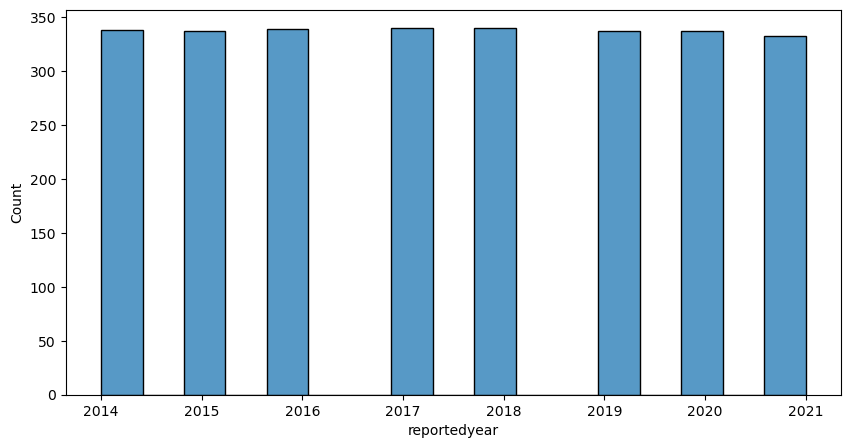

In [74]:
# Plot reportedyear counts
plt.figure(figsize=(10,5));
sns.histplot(df_trc_drop['reportedyear']);

### geodivision

In [57]:
# No. of unique divisions
df_trc_drop.geodivision.nunique()

17

In [58]:
# No. of divisons count
df_trc_drop.geodivision.value_counts()

D32        160
D52        160
D14        160
D41        160
D33        160
D54/D55    160
D22        160
D42        160
D12        159
D23        159
D51        159
D43        159
D11        159
D31        158
D13        158
D53        155
NSA        155
Name: geodivision, dtype: int64

### category

In [59]:
df_trc_drop.category.nunique()

6

In [60]:
df_trc_drop.category.value_counts()

Crimes Against Property                1222
Crimes Against the Person               799
Other Criminal Code Violations          272
Controlled Drugs and Substances Act     136
Criminal Code Traffic                   136
Other Federal Statute Violations        136
Name: category, dtype: int64

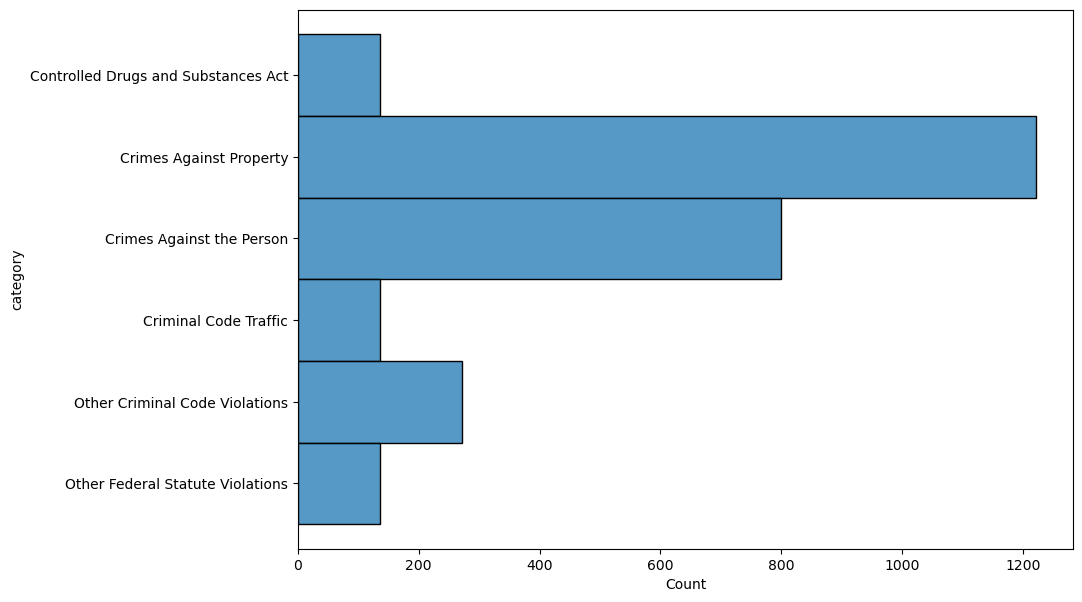

In [79]:
# Plot category counts
plt.figure(figsize=(10,7));
sns.histplot(y=df_trc_drop['category']);

### subtype

In [80]:
# No. of unique subtypes
df_trc_drop.subtype.nunique()

15

In [81]:
# counto of each subtype
df_trc_drop.subtype.value_counts()

Other                                            816
Auto Theft                                       136
Break & Enter-Apartment                          136
Break & Enter-Commercial                         136
Break & Enter-House                              136
Fraud                                            136
Theft Over $5000                                 136
Theft Under $5000                                136
Assault                                          136
Robbery-Other                                    136
Sexual Violation                                 136
Other Criminal Violations - Offensive Weapons    136
Break & Enter-Other                              134
Attempt Murder                                   128
Robbery-Financial                                127
Name: subtype, dtype: int64

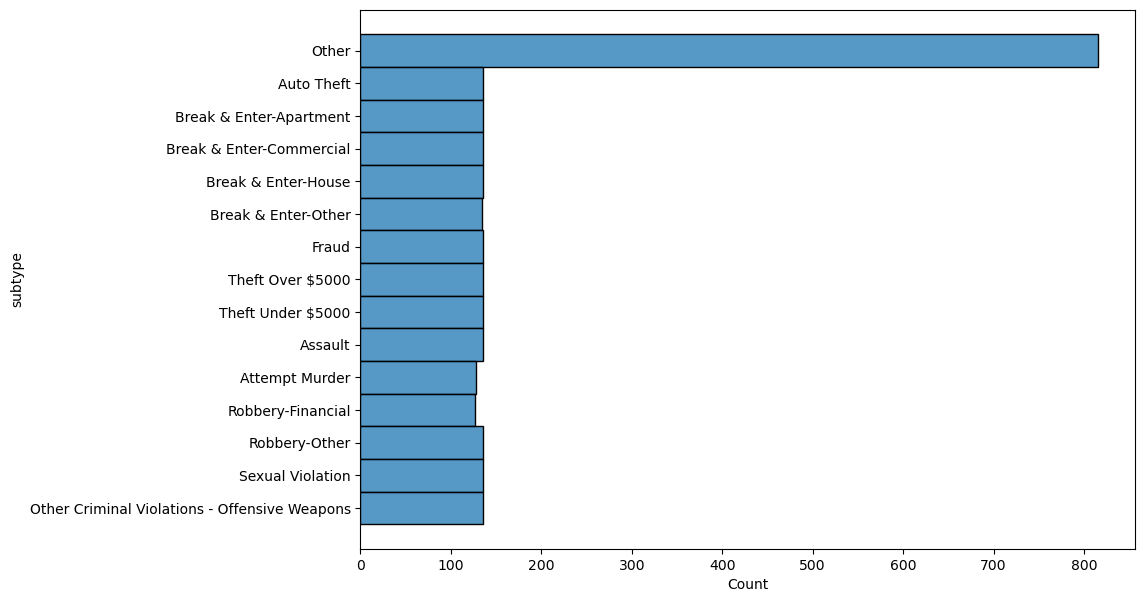

In [82]:
# Plot category counts
plt.figure(figsize=(10,7));
sns.histplot(y=df_trc_drop['subtype']);

### count

In [86]:
# Total reported crimes for all years
df_trc_drop['count'].sum()

1010128

## Bivariate analysis
In this section, we want ot understand how each feature changes with `count` feature.

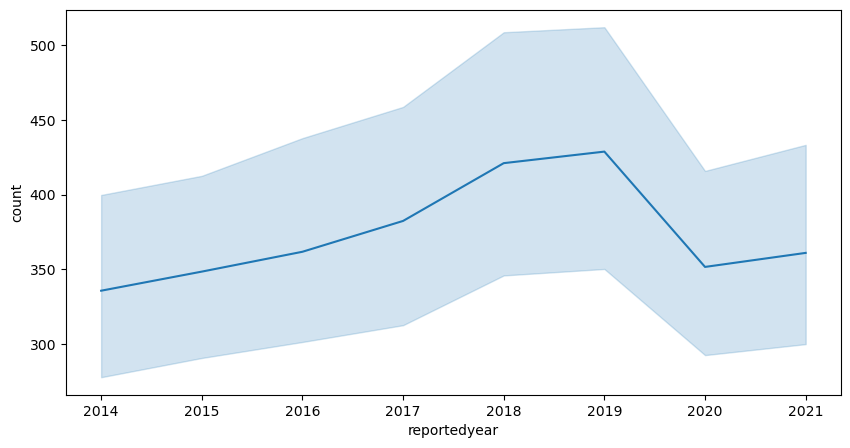

In [89]:
# plot reportedyear with count 
plt.figure(figsize=(10,5))
sns.lineplot(data=df_trc_drop, 
             x='reportedyear',
             y='count');

Above plot indicates that the total reported crimes increased from 2014 until 2019 and slowed down since then. 

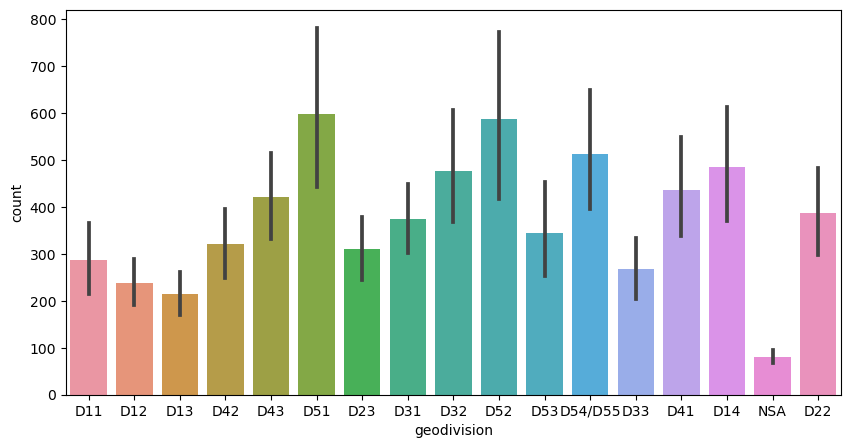

In [91]:
# plot geodivision with count 
plt.figure(figsize=(10,5))
sns.barplot(data=df_trc_drop, 
             x='geodivision',
             y='count');

It is clear from above plot that some division have more reported crimes than others. 

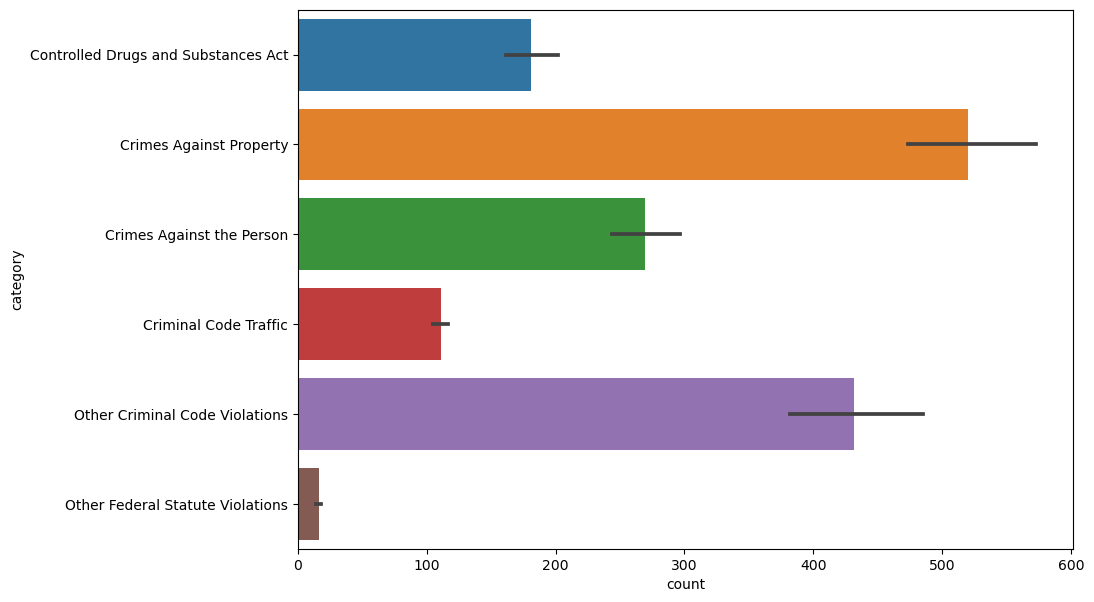

In [94]:
# plot category with count 
plt.figure(figsize=(10,7))
sns.barplot(data=df_trc_drop, 
             y='category',
             x='count');

Crime aginst property is the most reported crime across all years. 

## Multivariate analysis
In this section, we try to understand relationship between all features. 

In [105]:
df_trc_drop.corr()

,reportedyear,count
reportedyear,1.000000,0.017948
count,0.017948,1.000000


***

# Feature Importance

# Model training

# Exporting notebook to script

# Model deployment

# Reproducibility

# Dependency and environment management

# Containerization

# Cloud deployment